In [2]:
# Importing Libraries
import os
import re
import time
import pickle
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    ConfusionMatrixDisplay,
)

In [3]:
# (Optional) Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
def clean_text(text): # Basic cleaning: lowercase, strip spaces, remove non-alphanumeric (except space)
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    return text

def build_vocab(texts, min_freq=2):  # Build a vocabulary mapping for tokens that appear at least min_freq times.
    counter = Counter()
    for text in texts:
        tokens = text.split()
        counter.update(tokens)
    
    vocab = {"<pad>": 0, "<unk>": 1}
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    return vocab

In [6]:
# Class for the dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_seq_len=200):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        
    def __len__(self):
        return len(self.texts)
        
    def tokenize(self, text):
        return text.split()
    
    def numericalize(self, tokens):
        return [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
    
    def pad_sequence(self, seq):
        if len(seq) < self.max_seq_len:
            seq = seq + [self.vocab["<pad>"]] * (self.max_seq_len - len(seq))
        else:
            seq = seq[:self.max_seq_len]
        return seq
    
    def __getitem__(self, index):
        text = self.texts.iloc[index]
        label = self.labels.iloc[index]
        tokens = self.tokenize(text)
        nums = self.numericalize(tokens)
        nums = self.pad_sequence(nums)
        return torch.tensor(nums, dtype=torch.long), torch.tensor(label, dtype=torch.float)

In [7]:
# Positional Encoding in the Transformer Architecture
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [8]:
# Transformer Implementation
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, num_encoder_layers=2,
                 dim_feedforward=256, dropout=0.1, max_seq_len=200, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.pos_encoder(embedded)
        embedded = embedded.transpose(0, 1)
        transformer_out = self.transformer_encoder(embedded)
        pooled = transformer_out.mean(dim=0)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits.squeeze(1)

Vocabulary Size: 88569


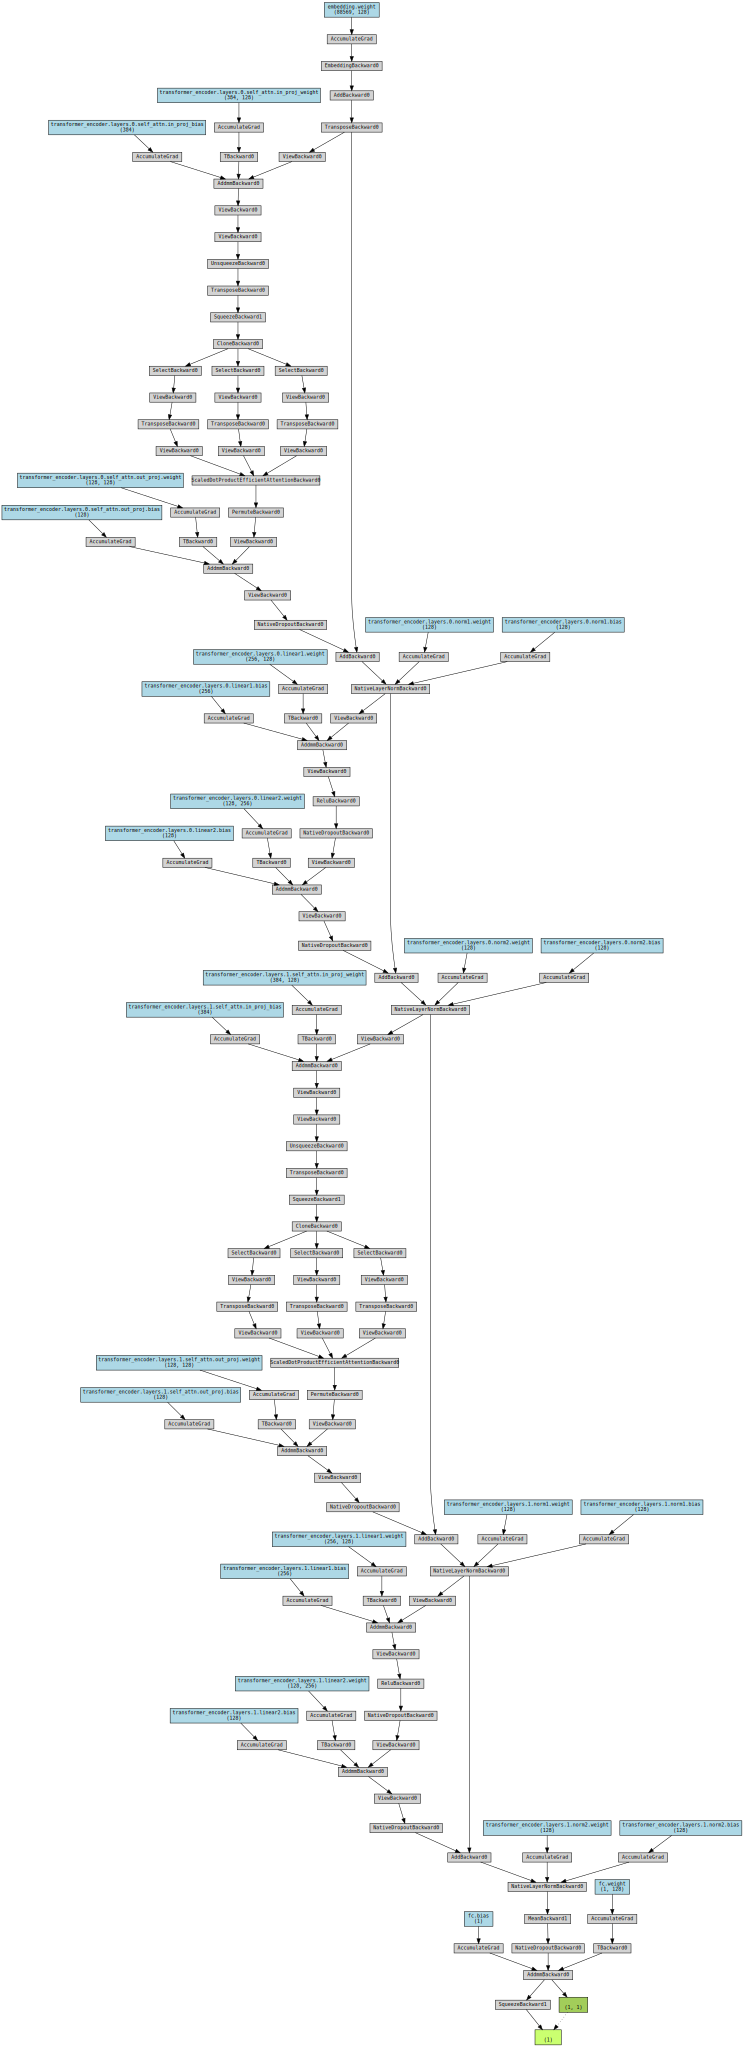

In [9]:
# Running the model on the dataset
true_df = pd.read_csv('/kaggle/input/news-dataset/True.csv')
fake_df = pd.read_csv('/kaggle/input/news-dataset/Fake.csv')

true_df['label'] = 1
fake_df['label'] = 0

true_df['content'] = true_df['title'].fillna('') + " " + true_df['text'].fillna('')
fake_df['content'] = fake_df['title'].fillna('') + " " + fake_df['text'].fillna('')

# Combining True and Fake
df = pd.concat([true_df, fake_df]).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = df['content'].apply(clean_text)

# 60-20-20 Train-Val-Test Split
X_temp, X_test, y_temp, y_test = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

vocab = build_vocab(X_train, min_freq=2)
print(f"Vocabulary Size: {len(vocab)}")

max_seq_len = 200
train_dataset = NewsDataset(X_train, y_train, vocab, max_seq_len=max_seq_len)
val_dataset   = NewsDataset(X_val, y_val, vocab, max_seq_len=max_seq_len)
test_dataset  = NewsDataset(X_test, y_test, vocab, max_seq_len=max_seq_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

vocab_size = len(vocab)
model = TransformerClassifier(vocab_size=vocab_size, 
                              embed_dim=128, 
                              nhead=4, 
                              num_encoder_layers=2,
                              dim_feedforward=256, 
                              dropout=0.1, 
                              max_seq_len=max_seq_len, 
                              num_classes=1)
model = model.to(device)

dummy_input = torch.randint(0, vocab_size, (1, max_seq_len)).to(device)
outputs = model(dummy_input)

dot = make_dot(outputs, params=dict(model.named_parameters()))
display(dot)

In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_loss = 0
    for batch_text, batch_labels in train_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_text)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_text.size(0)
    
    avg_train_loss = epoch_loss / len(train_dataset)
    train_loss_values.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_text, val_labels in val_loader:
            val_text = val_text.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_text)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_text.size(0)
    
    avg_val_loss = val_loss / len(val_dataset)
    val_loss_values.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

model.eval()
all_preds = []
all_probs = []
all_labels = []

# Testing
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        outputs = model(batch_text)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long().cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(batch_labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
precision = precision_score(all_labels, all_preds)

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    idx_eer = np.nanargmin(np.absolute((fnr - fpr)))
    eer_threshold = thresholds[idx_eer]
    eer = fpr[idx_eer]
    return eer, eer_threshold

eer, thresh = compute_eer(all_labels, all_probs)

print("\nEvaluation Metrics:")
print("-------------------")
print(f"Accuracy  : {accuracy:.4f}")
print(f"AUC       : {auc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"EER       : {eer:.4f} at threshold {thresh:.4f}")

model_save_path = "transformer_fake_news_model.pth"
torch.save(model.state_dict(), model_save_path)

vocab_save_path = "vocab.pkl"
with open(vocab_save_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Model saved to {model_save_path}")
print(f"Vocabulary saved to {vocab_save_path}")

Epoch 1/5, Train Loss: 0.0536, Val Loss: 0.0085
Epoch 2/5, Train Loss: 0.0097, Val Loss: 0.0088
Epoch 3/5, Train Loss: 0.0070, Val Loss: 0.0103
Epoch 4/5, Train Loss: 0.0039, Val Loss: 0.0087
Epoch 5/5, Train Loss: 0.0041, Val Loss: 0.0133

Evaluation Metrics:
-------------------
Accuracy  : 0.9979
AUC       : 0.9998
Precision : 0.9998
EER       : 0.0024 at threshold 0.0131
Model saved to transformer_fake_news_model.pth
Vocabulary saved to vocab.pkl


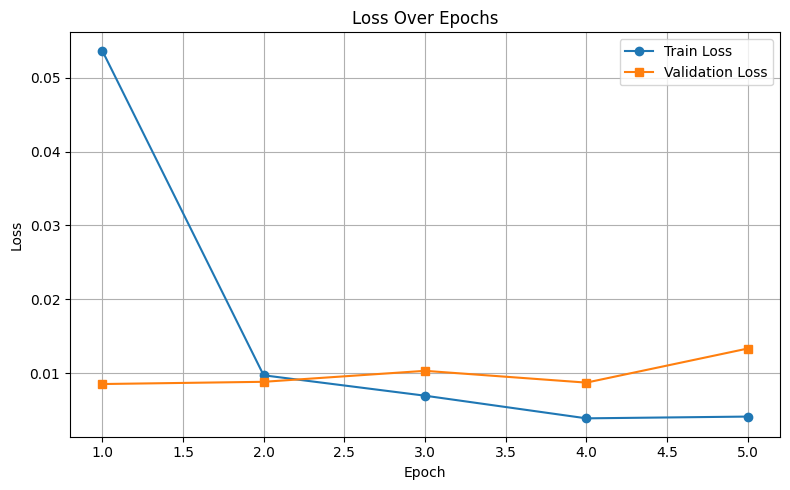

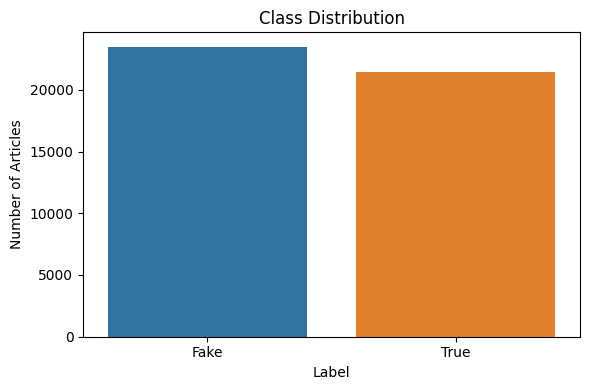

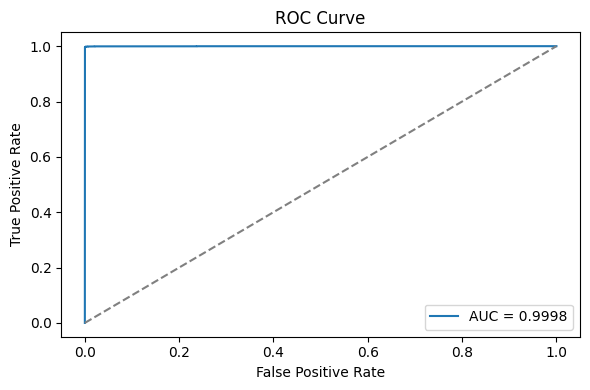

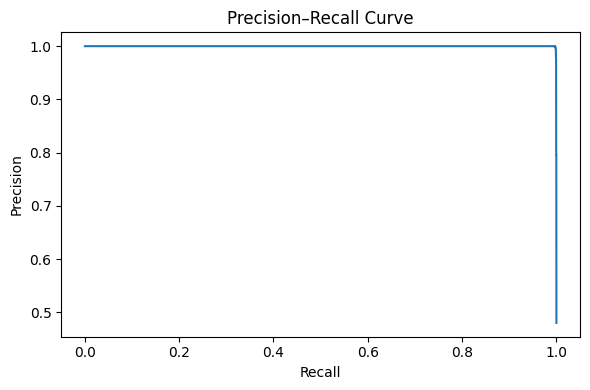

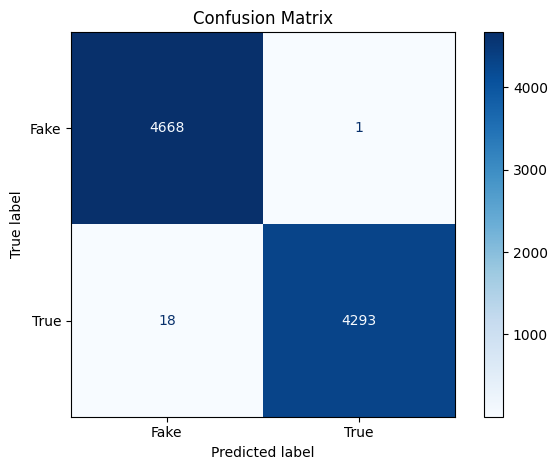

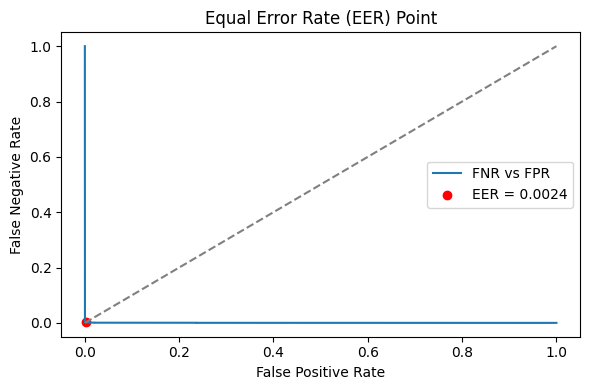

In [ ]:
# Plotting the metrics
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_loss_values, marker='s', label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('images/loss_epochs.png')
plt.show()

counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=['Fake','True'], y=counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Articles")
plt.xlabel("Label")
plt.tight_layout()
plt.savefig('images/class_distribution.png')
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('images/roc.png')
plt.show()

prec_vals, rec_vals, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6,4))
plt.plot(rec_vals, prec_vals, label="Precision–Recall")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.savefig('images/precision_recall.png')
plt.show()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "True"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.savefig('images/confusion_matrix.png')
plt.show()

fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer_fpr, eer_fnr = fpr[eer_idx], fnr[eer_idx]
plt.figure(figsize=(6,4))
plt.plot(fpr, fnr, label="FNR vs FPR")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.scatter([eer_fpr],[eer_fnr], color='red', label=f"EER = {eer_fpr:.4f}")
plt.title("Equal Error Rate (EER) Point")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('images/eer.png')
plt.show()